#**Toy Example: Manifold Projections**

![convergence-plot](https://github.com/howardheaton/howardheaton.github.io/blob/master/assets/images/adv-proj-plot.png?raw=true)

*Figure 1: The two trajectories plotted are a result of running this notebook. The purple path shows our result learning how to project onto a manifold (the light red half circle) using only the red sampled dots. The blue path shows the same algorithm using an analytic formula for the projection onto the manifold. Notice they converge to roughly the same point.*


![distance-landscape](https://github.com/howardheaton/howardheaton.github.io/blob/master/assets/images/adv-proj-landscape.png?raw=true)

*Figure 2: In order to perform the adversarial projection, we find a distance function describing the manifold. Above is a visualization of the distance function landscape for our manifold on the region [0,3]x[-0.5,2.5]. (This is obtained by finding the 1-Lipschitz function that solves an optimization problem, coinciding with the Wasserstein-1 distance.)*

</br>

**Created by:** Howard Heaton, Samy Wu Fung, Alex Tong Lin

**Date Created:** May 2020

**Date Updated:** October 6, 2020

_Note_: Through the menu you can save a copy of this code (File --> Save a Copy) and run it online through your own Google account (or run it locally on your computer if you have Jupyter set up).


**Overview**

This notebook has been created to provide a simple example for practitioners to gain intuition for how adversarial projections can be implemented. To achieve our goal of simplicity, we use a 2D example and shorten the code as much as possible (e.g., by removing the use of tensor dataloaders for batching). The notebook first consists of creating data (sampling from the manifold and generating samples to be projected onto the manifold). Then we define our neural network architecture and train the network to project the generated examples onto an approximation of the manifold. We say _approximation_ since we use only a discrete sampling of the manifold for learning (since this resembles practical situations). After training, we use these projections to solve a basic optimization problem involving least squares. There we illustrate how projected gradient (using an analytic formula for the true manifold) compares to our adversarially projected gradient method. The only distinction between the two methods is the operator used to project onto the manifold. As we will see, the learned projection generalizes surprisingly well for the sparsely sampled manifold.


**Data Creation**

We first generate samples from true manifold $\mathcal{M}$ given by the upper half circle of radius $0.75$ centered at $(2,0)$  so that each sample $u^\star \in \mathcal{M}$ takes the form

$u^\star =\left[\begin{array}{c} 2 \\ 0 \end{array}\right] + \dfrac{3}{4} \left[\begin{array}{c} \cos(\theta) \\ \sin(\theta) \end{array}\right]$ with $\theta \sim \mbox{Uniform}[0,\pi]$.

We will restrict our interest of use for the projection operator $P_{\mathcal{M}}$ to the region $[0,3]\times [-0.5,1.5]\subset \mathbb{R}^2$. 
So, we generate random samples in $\mathbb{R}^2$ to project onto $\mathcal{M}$ using

$u^1 = \left[\begin{array}{c} \xi_1 \\ \xi_2 \end{array}\right]$
with
$\xi_1 \sim \mbox{Uniform}[0,3]$ 
and 
$\xi_2 \sim \mbox{Uniform}[-0.5,1.5]$.

Running the following code cell creates the numpy arrays ```u_gen``` and ```u_true```, and then plots both of these in the plane.

_Note_: Although we only generate 100 samples below, we believe it is helpful to include a small amount of Gaussian noise to the samples in $u^1$. This ensures the distance function estimate is reasonable within a neighborhood of the points, and has been observed to yield improved results in our experiments.

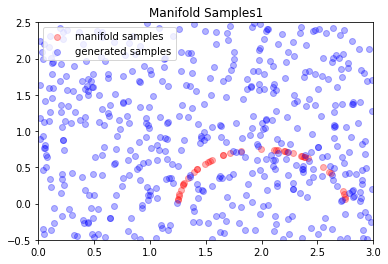

In [ ]:
import matplotlib
import os
import argparse
import torch
import torch.nn              as nn
import torch.optim           as optim
import matplotlib.pyplot     as plt
import numpy                 as np
from   mpl_toolkits.axes_grid1 import make_axes_locatable
from   torch.utils.data        import Dataset, TensorDataset, DataLoader
import time

device = "cpu" # cpu device
#-----------------------------------------------------------------
# Sampling and Batch Sizes
#-----------------------------------------------------------------
n_samples_man = 40  
n_samples     = 500 
#-----------------------------------------------------------------
# Manifold Data
#-----------------------------------------------------------------
u_true = torch.ones(n_samples_man, 2).to(device)
for i in range(n_samples_man):
    theta = torch.rand(1)
    r     = 1.5 
    u_true[i,0] = 2 + 0.5 * r * np.cos( 3.1415 * theta)
    u_true[i,1] = 0.5 * r * np.sin( 3.1415 * theta)
#-----------------------------------------------------------------
# Measurement Data
#-----------------------------------------------------------------
u_gen       = 3 * torch.rand(n_samples, 2).to(device)  
u_gen[:,1] -= 0.5
u_gen[:,0] += 0
u1          = u_gen.to(device)
#-----------------------------------------------------------------
# Plot Manifold Samples
#-----------------------------------------------------------------
x_min = 0
x_max = 3
y_min = -0.5
y_max = 2.5


def plot_distributions(dist1, dist2, index):
  fig = plt.figure()
  plt.scatter(dist1[:,0],dist1[:,1], c='r', alpha=0.3)
  plt.scatter(dist2[:,0],dist2[:,1], c='b', alpha=0.3)
  plt.ylim(y_min, y_max);
  plt.xlim(x_min, x_max)
  plt.legend(['manifold samples', 'generated samples'], loc='upper left',)
  title_str = 'Manifold Samples' + str(index)
  plt.title(title_str)
  plt.show()
  plt.close(fig)
  plt.close(plt.gcf())

plot_distributions(u_true, u_gen, 1)

def get_prefix(ctr): # Prefix for saving file names
    if ctr < 10:
        return '00000'
    elif ctr < 100:
        return '0000'
    elif ctr < 1000:
        return '000'
    elif ctr < 10000:
        return '00'
    elif ctr < 100000:
        return '0'
    else:
        return '' 

filename = './manifold.csv'
with open(filename, 'w') as f: 
  f.write('a,b\n')
  for file_ctr in range(u_true.shape[0]):     
    f.write('%0.5e,%0.5e\n' % (u_true[file_ctr, 0], u_true[file_ctr, 1]))   

filename = './p_' + get_prefix(1) + str(1) + '.csv'
with open(filename, 'w') as f: 
  f.write('a,b\n')
  for file_ctr in range(u_gen.shape[0]):     
    f.write('%0.5e,%0.5e\n' % (u_gen[file_ctr, 0], u_gen[file_ctr, 1])) 

**Network Definition**

The network structure used follows the ideas from the [GroupSort paper](http://proceedings.mlr.press/v97/anil19a/anil19a.pdf), which we highly recommend reading. In short, our neural net structure is 1-Lipschitz with respect to its inputs and (effectively) gradient norm preserving with respect to the training weights, which yields wonderful stability and the ability to approximate any 1-Lipschitz function arbitrarily well (with a sufficiently large network). In addition, we use a convex combination with the identity operator during feed forward operations, which acts similarly to a [ResNet idea](https://arxiv.org/pdf/1805.07477.pdf) and provides further stability (allowing us to easily train deep networks). Choosing $\beta < 1$ is not necessary in our simple problem. But, we note this still works fine (e.g., using $\beta=0.75$ gives roughly the same final result).

In [ ]:
class distance_estimator(nn.Module):
    def __init__(self, n_feats, n_hid_params, hidden_layers, n_projs, device, beta=0.5):
        super().__init__()        
        self.hidden_layers = hidden_layers  # number of hidden layers in the network
        self.n_projs       = n_projs        # number of projections to use for weights onto Steiffel manifold
        self.beta          = beta           # scalar in (0,1) for stabilizing feed forward operations
        
        # Intialize initial, middle, and final layers
        self.fc_one = torch.nn.Linear(n_feats, n_hid_params, bias=True )
        self.fc_mid = nn.ModuleList([torch.nn.Linear(n_hid_params, n_hid_params, bias=True ) for i in range(self.hidden_layers)])
        self.fc_fin = torch.nn.Linear(n_hid_params, 1, bias=True )

        # Normalize weights (helps ensure stability with learning rate)
        self.fc_one.weight = nn.Parameter(self.fc_one.weight/torch.norm(self.fc_one.weight))
        for i in range(self.hidden_layers):
            self.fc_mid.weight = nn.Parameter(self.fc_mid[i].weight/torch.norm(self.fc_mid[i].weight))          
        self.fc_fin.weight = nn.Parameter(self.fc_fin.weight/torch.norm(self.fc_fin.weight))
                        
    def forward(self, u):     
        u = self.fc_one(u).sort(1)[0]                             # Apply first layer affine mapping
        for i in range(self.hidden_layers):                       # Loop for each hidden layer                     
          u = u + self.beta * (self.fc_mid[i](u).sort(1)[0] - u)  # Convex combo of u and sort(W*u+b)
        u = self.fc_fin(u)                                        # Final layer is scalar (no need to sort)        
        J = torch.abs(u)        
        return J
                   
    
    def project_weights(self):
        self.fc_one.weight.data = self.proj_Stiefel(self.fc_one.weight.data, self.n_projs)
        for i in range(self.hidden_layers):
            self.fc_mid[i].weight.data = self.proj_Stiefel(self.fc_mid[i].weight.data, self.n_projs)
        self.fc_fin.weight.data = self.proj_Stiefel(self.fc_fin.weight.data, self.n_projs)           
            
    def proj_Stiefel(self, Ak, proj_iters):  # Project to closest orthonormal matrix
        n = Ak.shape[1]
        I = torch.eye(n)
        for k in range(proj_iters):
            Qk = I - Ak.permute(1, 0).matmul(Ak)
            Ak = Ak.matmul(I + 0.5 * Qk)
        return Ak

**Training Setup**

Training consists of learning a projection operator $P_{\mathcal{M}}$. This is an _intensive_ process. Once training is complete, we obtain a network $\phi:\mathbb{R}^2\rightarrow\mathbb{R}^2$ such that (hopefully)

$ \phi(u) \approx P_{\mathcal{M}}(u), \ \ \ \mbox{for all} \ u \in \mathcal{M}.$

Here

$\phi(u) = (T_K\circ T_{K-1}\circ\cdots \circ T_1)(u)$

where

$T_k(u) = (1-\beta) u + \beta \sigma (W^ku + c^k)$, for $k\in[K],$

$\sigma$ is the sorting operation, and $W^k$ and $c^k$ are a matrix and vector, respectively.

In [ ]:
n_hid_params   = 10    # Parameters in each hidden layer (10)
n_hid_layers   = 10    # Total hidden layers (10)
n_projs        = 2     # Number of projections to Stiefel manifold (2)
beta           = 1.0   # Relaxation parameter in network feed forward operations (1.0)
n_feats        = 2     # Our signals are in R^2
netD           = distance_estimator(n_feats, n_hid_params, n_hid_layers, n_projs, device, beta=beta)
max_epochs     = int(1e7)
learning_rate  = 2e-3   # (2e-3)
optimizer      = optim.SGD(netD.parameters(), lr=learning_rate)
drop_freq      = 1.0e5    # Frequency for decaying step sizes
decay_rate     = 1.0      # Step size decay proportion
prog_threshold = 1.0e-4   # Determines when to perform generator update
eta_threshold  = 0.75     # Minimum value of eta allowed to perform generator update
man_thresh     = 1.0e-2
n_steps        = 20
hist_dist      = np.zeros(n_steps)
hist_eta       = np.zeros(n_steps)
checkpt_path   = './models/'

def gamma(k): # Relaxation parameter used for Halpern updates
    return (1 + k) ** (-1)  

**Training**

Here we are trying the maximize the difference between our discriminator's values on the true data and the generated data. It is important to note that we train using a parameter $\eta$ described in the preprint. In short, this $\eta \in [0,1]$ gives an indication of the proportion of samples that we are able to detect outside the manifold. So, for example, $\eta = 0.34$ can be interpret to mean that our network detects that $34\%$ of the points are outside the manifold. If the samples are entirely outside the manifold, then we would ideally obtain $\eta\approx 1.0$ during training. So, as training progresses, the $\eta$ parameter will increase and we can use this to determine how "close" we are to obtaining our distance function $d_{\mathcal{M}}$ estimate. Moreover, because $\eta$ is restricted to the interval $[0,1]$, we can use the same stopping criterion for *all* the training, i.e., this is an absolute metric. (This is incredibly convenient since it is difficult to know how close one is to solving the problem looking only at the distance estimates...)

Note: The fact that the network is 1-Lipschitz makes is so we can have some insight into the choice of step-size to use.

distance_estimator(
  (fc_one): Linear(in_features=2, out_features=10, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Linear(in_features=10, out_features=10, bias=True)
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc_fin): Linear(in_features=10, out_features=1, bias=True)
)
[1: 1000/10000000] d(uk): 2.703e-02, d(man): 8.942e-03, eta = 0.006, eta-diff = 2.087e-04, lr 2.000e-03, timer 0.01
[1: 2000/10000000] d(uk): 8.262e-02, d(man): 9.506e-03, eta = 0.023, eta-diff = 6.713e-04, lr 2.000e-03, timer

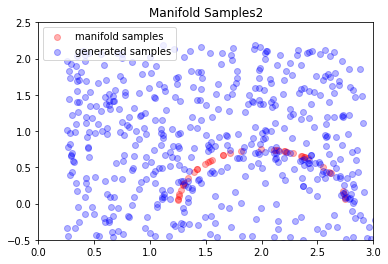

[2: 101000/10000000] d(uk): 6.815e-01, d(man): 1.785e-02, eta = 0.852, eta-diff = 4.063e-06, lr 2.000e-03, timer 0.01
[2: 102000/10000000] d(uk): 6.407e-01, d(man): 1.776e-02, eta = 0.851, eta-diff = 1.494e-06, lr 2.000e-03, timer 0.01
[2: 103000/10000000] d(uk): 6.259e-01, d(man): 1.766e-02, eta = 0.849, eta-diff = 5.494e-07, lr 2.000e-03, timer 0.01
[2: 104000/10000000] d(uk): 6.206e-01, d(man): 1.760e-02, eta = 0.848, eta-diff = 2.020e-07, lr 2.000e-03, timer 0.01
[2: 105000/10000000] d(uk): 6.188e-01, d(man): 1.745e-02, eta = 0.847, eta-diff = 7.428e-08, lr 2.000e-03, timer 0.01
[2: 106000/10000000] d(uk): 6.183e-01, d(man): 1.735e-02, eta = 0.847, eta-diff = 3.600e-07, lr 2.000e-03, timer 0.01
[2: 107000/10000000] d(uk): 6.183e-01, d(man): 1.728e-02, eta = 0.846, eta-diff = 1.324e-07, lr 2.000e-03, timer 0.01
[2: 108000/10000000] d(uk): 6.184e-01, d(man): 1.724e-02, eta = 0.846, eta-diff = 4.867e-08, lr 2.000e-03, timer 0.01
[2: 109000/10000000] d(uk): 6.186e-01, d(man): 1.719e-02

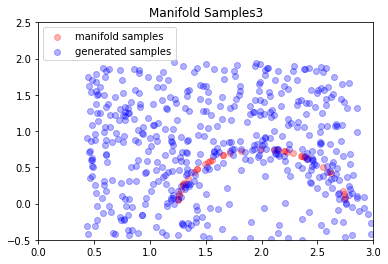

[3: 202000/10000000] d(uk): 5.473e-01, d(man): 1.625e-02, eta = 0.861, eta-diff = 1.045e-05, lr 2.000e-03, timer 0.01
[3: 203000/10000000] d(uk): 5.186e-01, d(man): 1.615e-02, eta = 0.861, eta-diff = 4.825e-06, lr 2.000e-03, timer 0.01
[3: 204000/10000000] d(uk): 5.081e-01, d(man): 1.607e-02, eta = 0.861, eta-diff = 1.775e-06, lr 2.000e-03, timer 0.01
[3: 205000/10000000] d(uk): 5.043e-01, d(man): 1.594e-02, eta = 0.861, eta-diff = 6.536e-07, lr 2.000e-03, timer 0.01
[3: 206000/10000000] d(uk): 5.029e-01, d(man): 1.589e-02, eta = 0.861, eta-diff = 2.427e-07, lr 2.000e-03, timer 0.01
[3: 207000/10000000] d(uk): 5.025e-01, d(man): 1.585e-02, eta = 0.861, eta-diff = 1.037e-07, lr 2.000e-03, timer 0.01
[3: 208000/10000000] d(uk): 5.023e-01, d(man): 1.578e-02, eta = 0.860, eta-diff = 4.329e-08, lr 2.000e-03, timer 0.01
[3: 209000/10000000] d(uk): 5.023e-01, d(man): 1.572e-02, eta = 0.860, eta-diff = 6.921e-07, lr 2.000e-03, timer 0.01
[3: 210000/10000000] d(uk): 5.023e-01, d(man): 1.578e-02

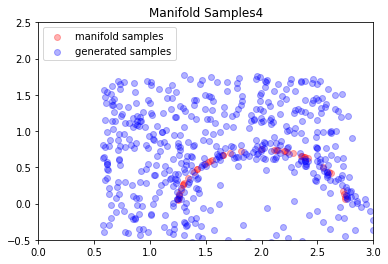

[4: 303000/10000000] d(uk): 4.478e-01, d(man): 1.458e-02, eta = 0.860, eta-diff = 8.952e-07, lr 2.000e-03, timer 0.01
[4: 304000/10000000] d(uk): 4.270e-01, d(man): 1.452e-02, eta = 0.857, eta-diff = 3.292e-07, lr 2.000e-03, timer 0.01
[4: 305000/10000000] d(uk): 4.194e-01, d(man): 1.452e-02, eta = 0.857, eta-diff = 1.210e-07, lr 2.000e-03, timer 0.01
[4: 306000/10000000] d(uk): 4.166e-01, d(man): 1.448e-02, eta = 0.856, eta-diff = 4.696e-08, lr 2.000e-03, timer 0.01
[4: 307000/10000000] d(uk): 4.156e-01, d(man): 1.444e-02, eta = 0.856, eta-diff = 2.323e-08, lr 2.000e-03, timer 0.01
[4: 308000/10000000] d(uk): 4.152e-01, d(man): 1.441e-02, eta = 0.855, eta-diff = 2.306e-08, lr 2.000e-03, timer 0.01
[4: 309000/10000000] d(uk): 4.151e-01, d(man): 1.435e-02, eta = 0.855, eta-diff = 1.035e-08, lr 2.000e-03, timer 0.01
[4: 310000/10000000] d(uk): 4.151e-01, d(man): 1.432e-02, eta = 0.855, eta-diff = 9.394e-09, lr 2.000e-03, timer 0.01
[4: 311000/10000000] d(uk): 4.151e-01, d(man): 1.430e-02

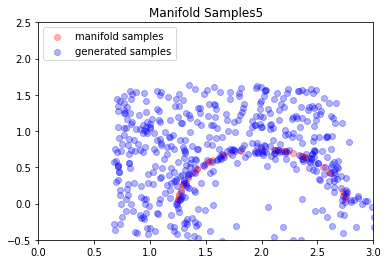

[5: 404000/10000000] d(uk): 3.745e-01, d(man): 1.330e-02, eta = 0.855, eta-diff = 9.359e-06, lr 2.000e-03, timer 0.01
[5: 405000/10000000] d(uk): 3.592e-01, d(man): 1.322e-02, eta = 0.855, eta-diff = 3.801e-06, lr 2.000e-03, timer 0.01
[5: 406000/10000000] d(uk): 3.536e-01, d(man): 1.312e-02, eta = 0.855, eta-diff = 1.450e-06, lr 2.000e-03, timer 0.01
[5: 407000/10000000] d(uk): 3.515e-01, d(man): 1.304e-02, eta = 0.855, eta-diff = 6.159e-07, lr 2.000e-03, timer 0.01
[5: 408000/10000000] d(uk): 3.508e-01, d(man): 1.310e-02, eta = 0.855, eta-diff = 4.981e-07, lr 2.000e-03, timer 0.01
[5: 409000/10000000] d(uk): 3.505e-01, d(man): 1.304e-02, eta = 0.855, eta-diff = 2.981e-07, lr 2.000e-03, timer 0.01
[5: 410000/10000000] d(uk): 3.504e-01, d(man): 1.303e-02, eta = 0.855, eta-diff = 6.805e-07, lr 2.000e-03, timer 0.01
[5: 411000/10000000] d(uk): 3.504e-01, d(man): 1.296e-02, eta = 0.855, eta-diff = 1.117e-06, lr 2.000e-03, timer 0.01
[5: 412000/10000000] d(uk): 3.505e-01, d(man): 1.290e-02

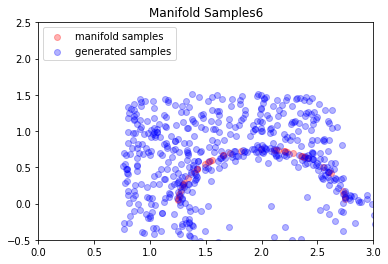

[6: 505000/10000000] d(uk): 3.196e-01, d(man): 1.200e-02, eta = 0.850, eta-diff = 3.143e-06, lr 2.000e-03, timer 0.01
[6: 506000/10000000] d(uk): 3.077e-01, d(man): 1.206e-02, eta = 0.848, eta-diff = 1.156e-06, lr 2.000e-03, timer 0.01
[6: 507000/10000000] d(uk): 3.034e-01, d(man): 1.201e-02, eta = 0.847, eta-diff = 4.298e-07, lr 2.000e-03, timer 0.01
[6: 508000/10000000] d(uk): 3.018e-01, d(man): 1.205e-02, eta = 0.846, eta-diff = 6.282e-07, lr 2.000e-03, timer 0.01
[6: 509000/10000000] d(uk): 3.012e-01, d(man): 1.201e-02, eta = 0.846, eta-diff = 5.556e-07, lr 2.000e-03, timer 0.01
[6: 510000/10000000] d(uk): 3.010e-01, d(man): 1.195e-02, eta = 0.846, eta-diff = 3.016e-06, lr 2.000e-03, timer 0.01
[6: 511000/10000000] d(uk): 3.010e-01, d(man): 1.199e-02, eta = 0.846, eta-diff = 3.981e-06, lr 2.000e-03, timer 0.01
[6: 512000/10000000] d(uk): 3.010e-01, d(man): 1.187e-02, eta = 0.846, eta-diff = 3.111e-06, lr 2.000e-03, timer 0.01
[6: 513000/10000000] d(uk): 3.010e-01, d(man): 1.182e-02

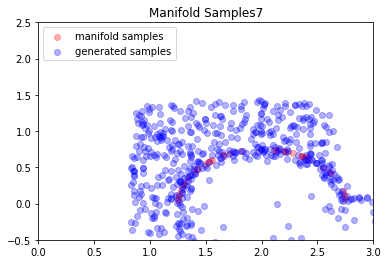

[7: 606000/10000000] d(uk): 2.776e-01, d(man): 1.147e-02, eta = 0.848, eta-diff = 4.346e-05, lr 2.000e-03, timer 0.01
[7: 607000/10000000] d(uk): 2.688e-01, d(man): 1.144e-02, eta = 0.849, eta-diff = 2.378e-05, lr 2.000e-03, timer 0.01
[7: 608000/10000000] d(uk): 2.656e-01, d(man): 1.137e-02, eta = 0.849, eta-diff = 1.125e-05, lr 2.000e-03, timer 0.01
[7: 609000/10000000] d(uk): 2.644e-01, d(man): 1.127e-02, eta = 0.849, eta-diff = 5.733e-06, lr 2.000e-03, timer 0.01
[7: 610000/10000000] d(uk): 2.640e-01, d(man): 1.140e-02, eta = 0.848, eta-diff = 3.292e-06, lr 2.000e-03, timer 0.01
[7: 611000/10000000] d(uk): 2.639e-01, d(man): 1.126e-02, eta = 0.848, eta-diff = 1.365e-06, lr 2.000e-03, timer 0.01
[7: 612000/10000000] d(uk): 2.639e-01, d(man): 1.118e-02, eta = 0.848, eta-diff = 1.696e-06, lr 2.000e-03, timer 0.01
[7: 613000/10000000] d(uk): 2.639e-01, d(man): 1.123e-02, eta = 0.848, eta-diff = 2.238e-06, lr 2.000e-03, timer 0.01
[7: 614000/10000000] d(uk): 2.639e-01, d(man): 1.110e-02

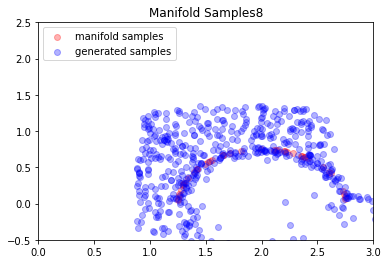

[8: 707000/10000000] d(uk): 2.442e-01, d(man): 1.065e-02, eta = 0.839, eta-diff = 2.074e-06, lr 2.000e-03, timer 0.01
[8: 708000/10000000] d(uk): 2.367e-01, d(man): 1.061e-02, eta = 0.837, eta-diff = 8.050e-07, lr 2.000e-03, timer 0.01
[8: 709000/10000000] d(uk): 2.339e-01, d(man): 1.054e-02, eta = 0.837, eta-diff = 1.009e-06, lr 2.000e-03, timer 0.01
[8: 710000/10000000] d(uk): 2.330e-01, d(man): 1.056e-02, eta = 0.836, eta-diff = 9.639e-07, lr 2.000e-03, timer 0.01
[8: 711000/10000000] d(uk): 2.327e-01, d(man): 1.047e-02, eta = 0.836, eta-diff = 1.685e-06, lr 2.000e-03, timer 0.01
[8: 712000/10000000] d(uk): 2.325e-01, d(man): 1.058e-02, eta = 0.836, eta-diff = 2.996e-06, lr 2.000e-03, timer 0.01
[8: 713000/10000000] d(uk): 2.324e-01, d(man): 1.048e-02, eta = 0.836, eta-diff = 5.936e-06, lr 2.000e-03, timer 0.01
[8: 714000/10000000] d(uk): 2.325e-01, d(man): 1.041e-02, eta = 0.836, eta-diff = 7.443e-06, lr 2.000e-03, timer 0.02
[8: 715000/10000000] d(uk): 2.325e-01, d(man): 1.052e-02

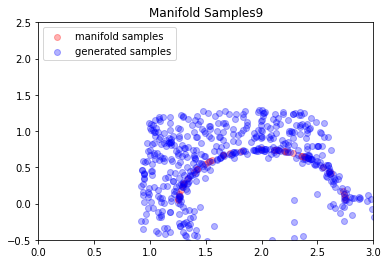

Saved Checkpoint:./models/step_000010.pth
[10: 808000/10000000] d(uk): 2.167e-01, d(man): 9.828e-03, eta = 0.831, eta-diff = 3.903e-06, lr 2.000e-03, timer 0.02


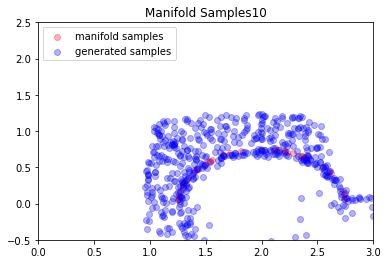

[10: 809000/10000000] d(uk): 1.974e-01, d(man): 1.017e-02, eta = 0.830, eta-diff = 4.669e-06, lr 2.000e-03, timer 0.01
[10: 810000/10000000] d(uk): 1.903e-01, d(man): 1.026e-02, eta = 0.830, eta-diff = 6.856e-06, lr 2.000e-03, timer 0.01
[10: 811000/10000000] d(uk): 1.877e-01, d(man): 1.014e-02, eta = 0.829, eta-diff = 4.674e-06, lr 2.000e-03, timer 0.01
[10: 812000/10000000] d(uk): 1.867e-01, d(man): 1.006e-02, eta = 0.829, eta-diff = 5.783e-06, lr 2.000e-03, timer 0.01
[10: 813000/10000000] d(uk): 1.864e-01, d(man): 1.006e-02, eta = 0.829, eta-diff = 5.959e-06, lr 2.000e-03, timer 0.02
Saved Checkpoint:./models/step_000011.pth
[11: 814000/10000000] d(uk): 1.863e-01, d(man): 9.985e-03, eta = 0.829, eta-diff = 9.999e-06, lr 2.000e-03, timer 0.02


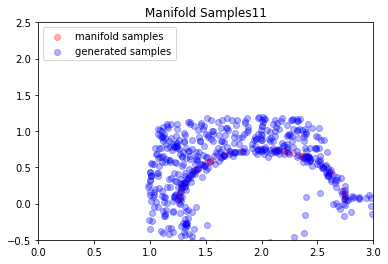

Saved Checkpoint:./models/step_000012.pth
[12: 815000/10000000] d(uk): 1.761e-01, d(man): 9.623e-03, eta = 0.827, eta-diff = 3.715e-06, lr 2.000e-03, timer 0.02


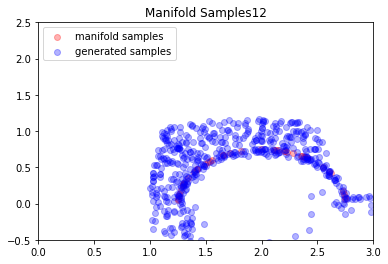

Saved Checkpoint:./models/step_000013.pth
[13: 816000/10000000] d(uk): 1.627e-01, d(man): 9.488e-03, eta = 0.823, eta-diff = 1.368e-06, lr 2.000e-03, timer 0.02


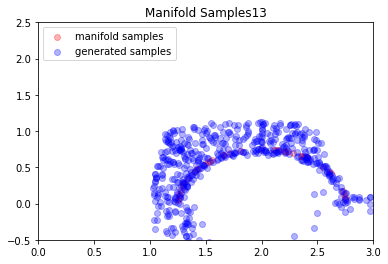

Saved Checkpoint:./models/step_000014.pth
[14: 817000/10000000] d(uk): 1.498e-01, d(man): 9.513e-03, eta = 0.820, eta-diff = 5.208e-07, lr 2.000e-03, timer 0.02


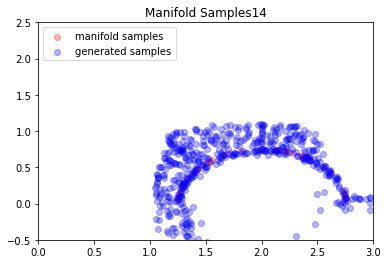

Saved Checkpoint:./models/step_000015.pth
[15: 818000/10000000] d(uk): 1.381e-01, d(man): 9.372e-03, eta = 0.818, eta-diff = 2.133e-07, lr 2.000e-03, timer 0.02


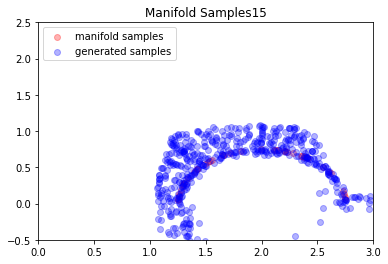

Saved Checkpoint:./models/step_000016.pth
[16: 819000/10000000] d(uk): 1.282e-01, d(man): 9.172e-03, eta = 0.816, eta-diff = 1.266e-07, lr 2.000e-03, timer 0.02


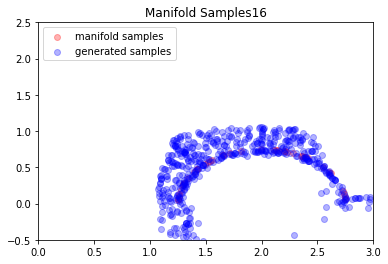

Saved Checkpoint:./models/step_000017.pth
[17: 820000/10000000] d(uk): 1.192e-01, d(man): 9.269e-03, eta = 0.811, eta-diff = 1.194e-07, lr 2.000e-03, timer 0.02


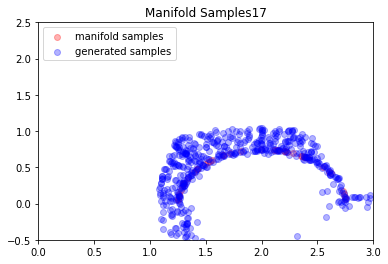

Saved Checkpoint:./models/step_000018.pth
[18: 821000/10000000] d(uk): 1.121e-01, d(man): 8.887e-03, eta = 0.809, eta-diff = 1.958e-07, lr 2.000e-03, timer 0.02


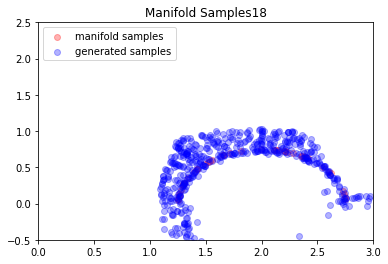

Saved Checkpoint:./models/step_000019.pth
[19: 822000/10000000] d(uk): 1.058e-01, d(man): 8.851e-03, eta = 0.805, eta-diff = 1.563e-07, lr 2.000e-03, timer 0.02


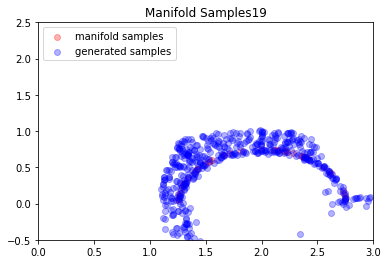

Saved Checkpoint:./models/step_000020.pth
[20: 823000/10000000] d(uk): 9.969e-02, d(man): 8.793e-03, eta = 0.802, eta-diff = 2.769e-07, lr 2.000e-03, timer 0.02


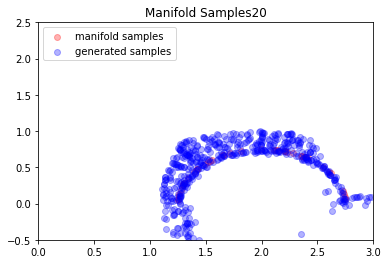

In [ ]:
#--------------------------------------
#  Initialize Training
#--------------------------------------
k        = 1  # defines the index for {u^k}
ave_diff = 0
ctr      = 1  # inner loop for solving the k-th minimization problem
eta      = 0.0
dist_est = 0.0
dist_man = 0.0
loss     = 0.0
eta_prev = 0.0
uk       = u_gen

print(netD) 
#------------------------------------------------------------
# Identify if stopping criteria are met for current step
#------------------------------------------------------------
def stop_crit_met(epoch, ave_diff, eta, prog_thresh, eta_thresh, ctr, k, dist_man):    
    if epoch%1000 != 0:           # Only update once every 100 epochs
        return False
    elif ctr > 100000:
        return True 
    elif ave_diff > prog_thresh: # Require estimate progress to be small (close to optimal)
        return False
    elif ave_diff == 0:          # Require their to be forward progress 
        return False    
    elif dist_man > man_thresh:
        return False
    elif eta < eta_thresh:
        return False
    return True
#------------------
# Training
#------------------
for epoch in range(1, max_epochs + 1):
    if k < n_steps:
        t0        = time.time()               
        optimizer.zero_grad()  # Initialize gradient to zero
        err_real     = torch.mean(netD(u_true))
        # err_fake     = torch.mean(netD(uk))

        # To artifically inflate P^k, we can include noise (following line)
        err_fake     = torch.mean(netD(uk + 0.02 * torch.randn(uk.shape)))

        err          = err_real - err_fake
        soft_const   = 50 * torch.mean(netD(u_true) ** 2) # tau = 50, p = 2
        loss         = err + soft_const
        dist_est     = -0.001 * err.detach() + 0.999 * dist_est            
        loss.backward()
        optimizer.step()  
        dist_man = 0.01 * err_real.detach().numpy() + 0.99 * dist_man
        netD.project_weights()
        uk.requires_grad_(True)
        Jout   = netD(uk)
        nablaJ = torch.autograd.grad(outputs=Jout, inputs=uk, # take derivative w.r.t only inputs
                                  grad_outputs=torch.ones(Jout.size()).to(device), only_inputs=True)[0]        
        eta      = 0.001 * (torch.norm(nablaJ, p=2, dim=1) ** 2).mean().cpu().numpy() + 0.999 * eta
        ave_diff = 0.001 * np.maximum(0, eta - eta_prev) + 0.999 * ave_diff
        ctr += 1        
        if ctr%100 == 0:
            eta_prev = eta
      
        if stop_crit_met(epoch, ave_diff, eta, prog_threshold, eta_threshold, ctr, k, dist_man):
          #------------------------------------
          # Update distribution estimate uk
          #------------------------------------                
          beta = dist_est
          uk.requires_grad_(True)
          Jout   = netD(uk)
          nablaJ = torch.autograd.grad(outputs=Jout, inputs=uk,   # Compute derivative w.r.t inputs
                                    grad_outputs=torch.ones(Jout.size()).to(device), only_inputs=True)[0]                                                   
          diag  = 0.25 * (beta + Jout)
          uk    = gamma(k) * u1 + (1-gamma(k)) * (uk - diag * nablaJ)  
          uk    = uk.detach()
          k    += 1 # update outer iteration number
          ctr   = 0 # Reset counter for stopping critera  
          #--------------------------
          # Save weights/step sizes
          #--------------------------
          state = {
            'epoch': epoch,
            'eta': eta,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'state_dict': netD.state_dict(),
            'beta' : beta,
            'ave_true': err_real.detach().cpu().numpy(),
          }         
          if not os.path.exists(os.path.dirname(checkpt_path)):
              print("created path: ", checkpt_path)
              os.makedirs(os.path.dirname(checkpt_path))
          save_checkpt_str = checkpt_path + 'step_' + get_prefix(k) + str(k) + '.pth'          
          torch.save(state, save_checkpt_str) 
          print('Saved Checkpoint:' + save_checkpt_str) 
        #------------------------
        # Update drop frequency
        #------------------------
        #if ctr % drop_freq == 0 and ctr > 0:
        #    optimizer.param_groups[0]['lr'] *= decay_rate        
        
  
        #------------------------
        # Output training stats
        #------------------------
        if epoch % 1000 == 0:
            print('[%d: %d/%d] d(uk): %.3e, d(man): %.3e, eta = %.3f, eta-diff = %0.3e, lr %.3e, timer %0.2f'
                % (k, epoch, max_epochs, dist_est, dist_man, eta, ave_diff, optimizer.param_groups[0]['lr'], time.time() - t0))
        #------------------------
        # Plot training data
        #------------------------
        if ctr == 0:
            plot_distributions(u_true.detach(), uk.detach(), k)        
        # ------------------------
        # Evaluate J on 2D grid
        # ------------------------        
        if ctr % 1000 == 0:
            fig = plt.figure()
            a = torch.linspace(0, 3, 200)
            b = torch.linspace(2.5, -0.5, 200)
            gridPts   = torch.stack(torch.meshgrid(a, b)).to(device)
            gridShape = gridPts.shape[1:]
            gridPts   = gridPts.reshape(2, -1).t()
            disc_grid = netD(gridPts)
            disc_grid = disc_grid.detach().cpu()
            
            plt.imshow(disc_grid.reshape(gridShape).t())
            plt.clim(0,2.5)
            plt.colorbar()
            J_title_str = 'Manifold Distance Function Landscape:' + str(k)
            fig.savefig('distance_landscape_' + get_prefix(epoch+1) + str(epoch+1) + '.png')
            
            plt.title(J_title_str)
            plt.close(fig)
            plt.close(plt.gcf())

The following snippet of code is used for outputting the distance


# Application of Adversarial Projection to Toy Problem


**Toy Example Problem**

We consider the problem

$\displaystyle \min_{z\in \mathbb{R}^2} H(z) + \delta_{\mathcal{M}}(z) = \min_{z \in \mathcal{M}} H(z),$

where

$H(u) := \dfrac{1}{2}\|Au-b\|_2^2,$

and $A = [1\ \  2]$ and $b = 2$.

The iterative method we use to solve this problem is a relaxed version of projected gradient. For $\tau \in (0,1)$ and $\kappa \in (0, 2/\mbox{Lip}(H))$, we use relaxed projected gradient updates of the form


$\ \ \ z^{t+1} = (1-\tau)\cdot z^t + \tau\cdot P_{\mathcal{M}}(z^t - \alpha \nabla H(z^t))$.

</br>

Here we load the model parameters stored during our training to test our model on the problem above. We include two variations. One plot is of the trajectory using an analytic formula for the projection onto the manifold. The other uses our learned version, called adversarial projection.

In [ ]:
# Save file....
def heat_map(index):
    netD        = distance_estimator(n_feats, n_hid_params, n_hid_layers, n_projs, device, beta=1.0);
    load_path   = './models/step_' + get_prefix(index) + str(index) + '.pth'
    checkpt     = torch.load(load_path, map_location="cpu")
    netD.load_state_dict(checkpt["state_dict"])
       
    filename = './heat_map.txt'
    img_size = 64
    with open(filename, 'w') as f:    
      heat_map = np.zeros((img_size, img_size))
      for i in range(img_size):
        f.write('{')
        for j in range(img_size):
          x         = x_min + j * (x_max - x_min) / img_size
          y         = y_max + i * (y_min - y_max) / img_size
          point     = np.array([[x,y]])
          point_ten = torch.from_numpy(point).float()
          dist      = 100 / 2.5 * netD(point_ten).detach().float()
          if j == (img_size-1):
            f.write('%0.1f' % (dist))
          else:
            f.write('%0.1f,' % (dist))
        if i < img_size-1:
          f.write('},\n')
        else:
          f.write('},')        
      print('Saved heat map.')

heat_map(2)

Saved heat map.


In [ ]:
def proj_M_L2O(uk):
    uk      = torch.from_numpy(uk)
    u1      = uk
    n_steps = 20 
    netD    = distance_estimator(n_feats, n_hid_params, n_hid_layers, n_projs, device, beta=1.0);
    #---------------------------------------------------------------------------
    # Begin push forward
    #---------------------------------------------------------------------------
    for k in range(2,n_steps+1):   
        #-----------------------------------------------------------------------
        # Load network state:
        #-----------------------------------------------------------------------
        resume_path = './models/step_' + get_prefix(k) + str(k) + '.pth'
        checkpt     = torch.load(resume_path, map_location="cpu")
        netD.load_state_dict(checkpt["state_dict"])
        #-----------------------------------------------------------------------
        # Compute J(u_true), J(u_gen), eta
        #-----------------------------------------------------------------------
        uk.requires_grad_(True)
        Jtrue = netD(u_true).mean()
        Jgen  = netD(uk.float()).mean()
        # take derivative w.r.t only inputs
        nablaJ = torch.autograd.grad(outputs=Jgen, inputs=uk,
                                  grad_outputs=torch.ones(Jgen.size()).to("cpu"), only_inputs=True)[0]
        if k > 1: # Update u^k --> u^(k+1)
            beta  = checkpt["beta"]
            diag  = 0.25 * (beta + Jgen)
            uk    = gamma(k) * u1 + (1-gamma(k)) * (uk - diag * nablaJ)
    proj = uk.detach().numpy()
    return np.transpose(proj)
#-------------------------------------------------------------------------------
# Define the fixed quantities for the toy example
#-------------------------------------------------------------------------------
A  = np.array([[1, 2]])
z1 = np.array([[1.0], [2.0]])
b  = np.array([[2.25]])
c  = np.array([[2.0], [0.0]])
L  = np.linalg.norm(np.matmul(np.transpose(A),A))
#-------------------------------------------------------------------------------
# Algorithm Parameters
#-------------------------------------------------------------------------------
tau     = 0.2
alpha   = 1.0 / L 
n_iters = 20
#-------------------------------------------------------------------------------
# Arrays for Plotting Results
#-------------------------------------------------------------------------------
trajL2O        = np.zeros((n_iters,2))
trajRPG        = np.zeros((n_iters,2))
feasible_set1  = np.zeros((100, 2))
feasible_set2  = np.zeros((100, 2))
manifold       = np.zeros((100, 2))
#-------------------------------------------------------------------------------
# Algorithm Operators
#-------------------------------------------------------------------------------
def grad_H(u): # gradient of least squares
    return np.matmul(np.transpose(A), np.matmul(A,u) - b)
def proj_M(u): # projection onto M
    return c + 0.75*(u - c) / np.linalg.norm(u - c)
#-------------------------------------------------------------------------------
# Analytic Projected Gradient
#-------------------------------------------------------------------------------
zt = z1
trajRPG[0, :] = np.transpose(zt)
for t in range(n_iters - 1):
    yt = zt - alpha * grad_H(zt)
    zt = (1 - tau) * zt + tau * proj_M(yt)
    trajRPG[t+1, :] = np.transpose(zt)
#-------------------------------------------------------------------------------
# Adversarially Projected Gradient
#-------------------------------------------------------------------------------
zt = z1
trajL2O[0, :] = np.transpose(zt)
for t in range(n_iters - 1):
    yt = zt - alpha * grad_H(zt)
    zt = (1 - tau) * zt + tau * proj_M_L2O(np.transpose(yt))
    trajL2O[t+1, :] = np.transpose(zt)
    if t%5 == 0:
        print('Completed Step ', t)
#-------------------------------------------------------------------------------
# Create Feasible Set and Manifold
#-------------------------------------------------------------------------------
for i in range(100):
    temp = (1 - i / 100) * np.array([[0],[b[0,0]/2]]) + (i / 100.0) * np.array([[b[0,0]],[0]])
    feasible_set1[i, :] = np.transpose(temp)
    #temp = (1 - i / 100) * np.array([[0],[b[1,0]]]) + (i / 100.0) * np.array([[b[1,0]],[0]])
    #feasible_set2[i, :] = np.transpose(temp)

    temp = np.array([[2],[0]]) + 0.75 * np.array([[np.cos(i * 3.14/100)],[np.sin(i * 3.14/ 100)]])
    manifold[i, :]  = np.transpose(temp)

print('Iterations Complete.')

filename = './rpg_adversarial.csv'
with open(filename, 'w') as f: 
  f.write('a,b\n')
  for file_ctr in range(trajL2O.shape[0]):     
    f.write('%0.5e,%0.5e\n' % (trajL2O[file_ctr, 0], trajL2O[file_ctr, 1])) 

filename = './rpg_analytic.csv'
with open(filename, 'w') as f: 
  f.write('a,b\n')
  for file_ctr in range(trajRPG.shape[0]):     
    f.write('%0.5e,%0.5e\n' % (trajRPG[file_ctr, 0], trajRPG[file_ctr, 1]))     

Completed Step  0
Completed Step  5
Completed Step  10
Completed Step  15
Iterations Complete.


**Plotting Example Results**

Below we output results of applying the projection scheme to our toy problem (alongside trajectories for the analytic projection).

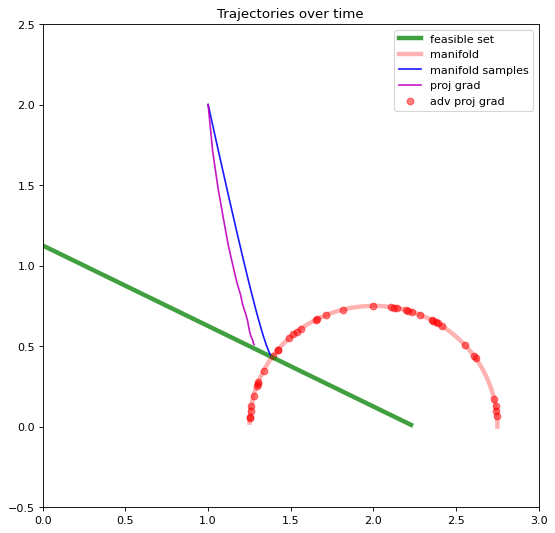

In [ ]:
#-----------------------------------------------------------------
# Create Plots
#-----------------------------------------------------------------
fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(feasible_set1[:,0],feasible_set1[:,1], c='g', alpha=0.75, linewidth=4,)
plt.plot(manifold[:,0],manifold[:,1], c='r', alpha=0.3, linewidth=4,)
plt.scatter(u_true[:,0].detach(), u_true[:,1].detach(), c='r', alpha=0.5)
plt.plot(trajRPG[:,0], trajRPG[:,1], c='b', alpha=0.9)
plt.plot(trajL2O[:,0], trajL2O[:,1], c='m', alpha=0.9)

plt.ylim(-0.5, 2.5);
plt.xlim(-0, 3)
plt.legend(['feasible set', 'manifold',  'proj grad', 'adv proj grad', 'manifold samples', ], loc='upper right',)
title_str = 'Trajectories over time'
plt.title(title_str)
plt.show()
plt.close(fig)